# Pneumonia Detection from Chest X-Rays: Modeling and Inference

### Content:
- [Part 1. Build and Train Model](#Part-1.-Build-and-Train-Model)
    - [1.1 Early processing of data](#1.1-Early-processing-of-data)
    - [1.2 Create training, validation and testing datasets](#1.2-Create-training,-validation-and-testing-datasets)
    - [1.3 Augment images and create data generators](#1.3-Augment-images-and-create-data-generators)
    - [1.4 Build model](#1.4-Build-model)
    - [1.5 Train model](#1.5-Train-model)
    - [1.6 Evaluate model](#1.6-Evaluate-model)
    
- [Part 2. Inference](#Part-2.-Inference)

In [1]:
import os
import math
import glob
from itertools import chain

import numpy as np
import pandas as pd
from random import sample

from PIL import ImageFile

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sklearn.metrics as skmetrics
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score,classification_report

from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization

## Part 1. Build and Train Model

### 1.1 Early processing of data
[Go back to top](#Content:)

In [2]:
all_xray_df = pd.read_csv('../data/Data_Entry_2017.csv')

# get paths for all images, output is a dic
all_image_paths = {os.path.basename(x): x for x in glob.glob(os.path.join('../data', 'images*', '*', '*.png'))}
print('Entries found: ', all_xray_df.shape[0], ', Scans found: ', len(all_image_paths))

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Entries found:  112120 , Scans found:  112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
99945,00026469_009.png,Atelectasis,9,26469,23,M,AP,3056,2544,0.139,0.139,../data\images\images_011\00026469_009.png
67621,00016716_002.png,No Finding,2,16716,44,F,AP,2500,2048,0.168,0.168,../data\images\images_008\00016716_002.png
101450,00026963_008.png,No Finding,8,26963,41,F,AP,3056,2544,0.139,0.139,../data\images\images_011\00026963_008.png


In [3]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print('All labels ({}): {}'.format(len(all_labels), all_labels))

All labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [4]:
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)

all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
83145,00020427_007.png,No Finding,7,20427,18,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
103116,00027476_000.png,No Finding,0,27476,73,M,PA,2500,2681,0.143,...,0,0,0,0,0,1,0,0,0,0
12049,00003140_005.png,No Finding,5,3140,30,F,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0


In [5]:
all_xray_df['Pneumonia_class'] = all_xray_df.apply(lambda row: '1' if row.Pneumonia==1 else '0', axis=1)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
82812,00020341_004.png,Atelectasis,4,20341,61,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
87110,00021494_014.png,No Finding,14,21494,38,F,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,0
105754,00028459_000.png,No Finding,0,28459,36,M,PA,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,0


In [6]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y',
       'path', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax', 'Pneumonia_class'],
      dtype='object')

In [7]:
# the percentage of Pneumonia patients. It is too small so we need to balance data.

all_xray_df['Pneumonia'].sum() / len(all_xray_df)

0.012763110952550838

### 1.2 Create training, validation and testing datasets
[Go back to top](#Content:)

In [8]:
# stratify according to Pneumonia cases
train_data, valid_data = train_test_split(all_xray_df, test_size=0.2, stratify=all_xray_df['Pneumonia'])

# balance training data: make number of Pneumonia patients = Non Pneumonia patients
pneumonia_idxes = train_data[train_data.Pneumonia_class=='1'].index.tolist()
non_pneumonia_indxes = train_data[train_data.Pneumonia_class=='0'].index.tolist()
perct_before = train_data['Pneumonia'].sum() / len(train_data)
print('Before balancing, training dataset contains {} cases.'.format(len(train_data)))
print('Pneumonia takes {:.2f}% of training data.'.format(perct_before*100))

non_pneumonia_sample = sample(non_pneumonia_indxes, len(pneumonia_idxes))
train_data = train_data.loc[pneumonia_idxes + non_pneumonia_sample]
perct_after = train_data['Pneumonia'].sum() / len(train_data)
print('\nAfter balancing, training dataset contains {} cases.'.format(len(train_data)))
print('Pneumonia takes {:.2f}% of training data.'.format(perct_after*100))

# make the ratio of Pneumonia/Non Pneumonia to be about 1:3, in validation dataset
pneumonia_idxes2 = valid_data[valid_data.Pneumonia_class=='1'].index.tolist()
non_pneumonia_idxes2 = valid_data[valid_data.Pneumonia_class=='0'].index.tolist()

non_peunomia_sample2 = sample(non_pneumonia_idxes2, len(pneumonia_idxes2)*3)
valid_data = valid_data.loc[pneumonia_idxes2 + non_peunomia_sample2]
perct_valid = valid_data['Pneumonia'].sum() / len(valid_data)
print('\nValidation dataset contains {} cases.'.format(len(valid_data)))
print('Pneumonia takes {:.2f}% of validation data.'.format(perct_valid*100))

Before balancing, training dataset contains 89696 cases.
Pneumonia takes 1.28% of training data.

After balancing, training dataset contains 2290 cases.
Pneumonia takes 50.00% of training data.

Validation dataset contains 1144 cases.
Pneumonia takes 25.00% of validation data.


### 1.3 Augment images and create data generators
[Go back to top](#Content:)

In [9]:
# image augmentation: no vertical slip for medical images; no need to augment validation images. 

def image_augmentation(train=True):
    train_idg = ImageDataGenerator(rescale=1.0/255.0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   rotation_range=10,
                                   shear_range=0.1,
                                   zoom_range=0.1)
    
    valid_idg = ImageDataGenerator(rescale=1.0/255.0)
    
    if train:
        return train_idg
    else:
        return valid_idg

In [10]:
TRAIN_BATCH_SIZE = 32
def create_train_generator(train_df, img_size):
    train_idg = image_augmentation(train=True)
    
    train_gen = train_idg.flow_from_dataframe(dataframe=train_df,
                                              directory=None,
                                              x_col='path',
                                              y_col='Pneumonia_class',
                                              class_mode='binary',
                                              target_size=img_size,
                                              batch_size=TRAIN_BATCH_SIZE,
                                              shuffle=True)
    
    return train_gen

def create_valid_generator(valid_df, img_size, batch_size):
    valid_idg = image_augmentation(train=False)
    
    valid_gen = valid_idg.flow_from_dataframe(dataframe=valid_df,
                                              directory=None,
                                              x_col='path',
                                              y_col='Pneumonia_class',
                                              class_mode='binary',
                                              target_size=img_size,
                                              batch_size=batch_size)
    
    return valid_gen

In [11]:
IMG_SIZE = (224, 224)
train_gen = create_train_generator(train_data, IMG_SIZE)

Found 2290 validated image filenames belonging to 2 classes.


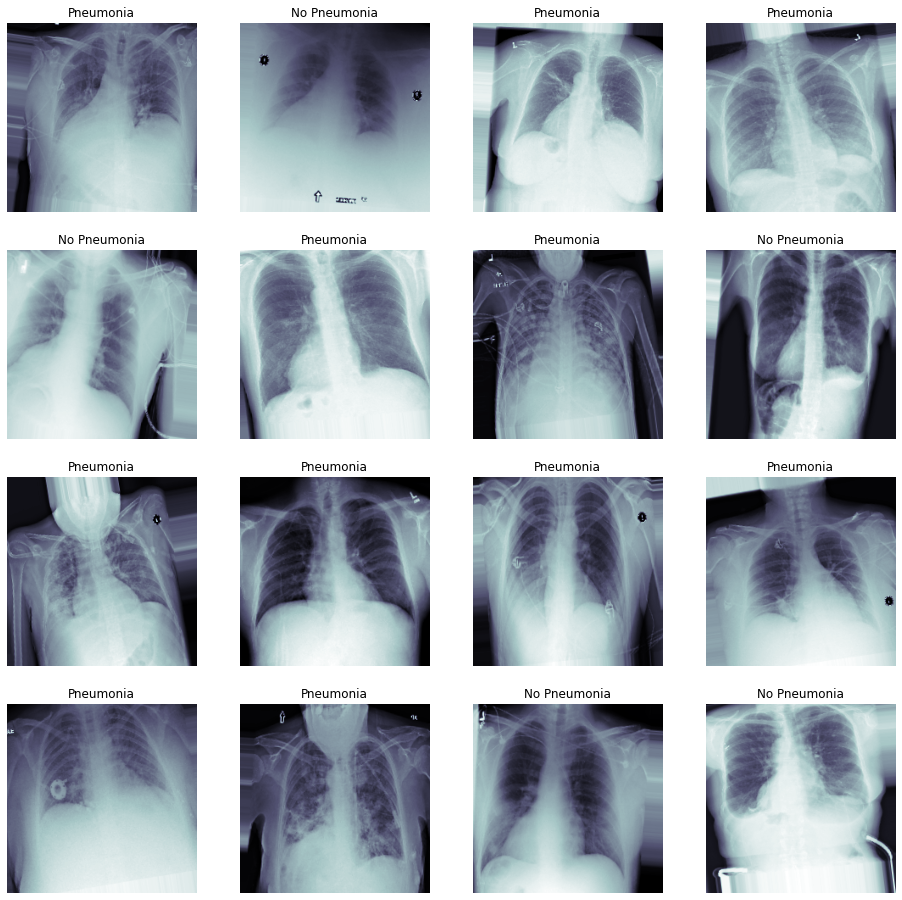

In [12]:
# pull a random batch from training data to get the taste of image augmentation
sample_x, sample_y = train_gen.next()

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for (x, y, ax) in zip(sample_x, sample_y, axs.flatten()):
    ax.imshow(x[:,:,0], cmap='bone')
    if y == 1:
        ax.set_title('Pneumonia')
    else:
        ax.set_title('No Pneumonia')
    ax.axis('off')

### 1.4 Build model
[Go back to top](#Content:)     

In [13]:
# use pre-trained network (vgg16) from Keras

def load_pretrained_model(transfer_layer):
    vgg16 = VGG16(include_top=True, weights='imagenet')
    
    transfer_layer = vgg16.get_layer(transfer_layer)
    vgg16_pre = Model(inputs=vgg16.input, outputs=transfer_layer.output)
    
    return vgg16_pre

In [14]:
def build_model(transfer_layer, freeze_layers):
    
    vgg16 = load_pretrained_model(transfer_layer)
    
    # freeze all but the last convolutional layer
    for layer in vgg16.layers[0: freeze_layers]:
        layer.trainable = False
        
    # build new model
    model = Sequential()
    
    # add the convolutional part of the VGG16 model from above
    model.add(vgg16)       
    
    # flatten the output of the VGG16 model because it is from a convolutional layer
    model.add(Flatten())
    
    # add dense layers. this is for combining features that the VGG16 model has recognized in the image
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # set optimizer, loss function and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [15]:
transfer_layer = 'block5_pool'
freeze_layers = 17

model = build_model(transfer_layer, freeze_layers)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 28,051,969
Non-trainable params: 12,354,880
_________________________________________________________________


In [17]:
# save model architecture to a .json file
model_json = model.to_json()
model_path = '{}_model_arch.json'.format('xray_class')
with open(model_path, 'w') as json_file:
    json_file.write(model_json)

In [18]:
# Add checkpoints and save the best model version by comparing it to previous epochs of training
# The model will train for ten epochs without seeing improvement before quitting

weight_path = '{}_model_weights.best.hdf5'.format('xray_class')

checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_binary_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max',
                             save_weights_only=True)

early = EarlyStopping(monitor='val_binary_accuracy',
                      mode='max',
                      patience=10)

callbacks_list = [checkpoint, early]

### 1.5 Train model   
[Go back to top](#Content:)

In [19]:
# take a small batch from the validation dataset for testing after every epoch

ImageFile.LOAD_TRUNCATED_IMAGES = True

VALID_SIZE = len(valid_data)
valid_gen = create_valid_generator(valid_data, IMG_SIZE, VALID_SIZE)
validX, validY = valid_gen.next()  

Found 1144 validated image filenames belonging to 2 classes.


In [20]:
steps_per_epoch = math.ceil(len(train_data) / TRAIN_BATCH_SIZE)
history = model.fit(train_gen,
                    validation_data=(validX, validY),
                    steps_per_epoch=steps_per_epoch,
                    epochs=40,
                    callbacks=callbacks_list)

Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 0.7169 - binary_accuracy: 0.5790
Epoch 00001: val_binary_accuracy improved from -inf to 0.73077, saving model to xray_class_model_weights.best.hdf5
72/72 [==============================] - 78s 1s/step - loss: 0.7169 - binary_accuracy: 0.5790 - val_loss: 0.5592 - val_binary_accuracy: 0.7308
Epoch 2/40
72/72 [==============================] - ETA: 0s - loss: 0.6522 - binary_accuracy: 0.6197
Epoch 00002: val_binary_accuracy did not improve from 0.73077
72/72 [==============================] - 55s 767ms/step - loss: 0.6522 - binary_accuracy: 0.6197 - val_loss: 0.5661 - val_binary_accuracy: 0.7177
Epoch 3/40
72/72 [==============================] - ETA: 0s - loss: 0.6334 - binary_accuracy: 0.6354
Epoch 00003: val_binary_accuracy did not improve from 0.73077
72/72 [==============================] - 54s 748ms/step - loss: 0.6334 - binary_accuracy: 0.6354 - val_loss: 0.7203 - val_binary_accuracy: 0.5621
Epoch 4/40
72/72 [=====

In [21]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [22]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))
    legends = ['Training', 'Validation']
    
    plt.subplot(1,2,1)
    plt.ylim([0, 1.5])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(legends, loc='upper left')
    
    plt.subplot(1,2,2)
    plt.ylim([0, 1.0])
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(legends, loc='upper left')
    
    plt.tight_layout()
    
    return

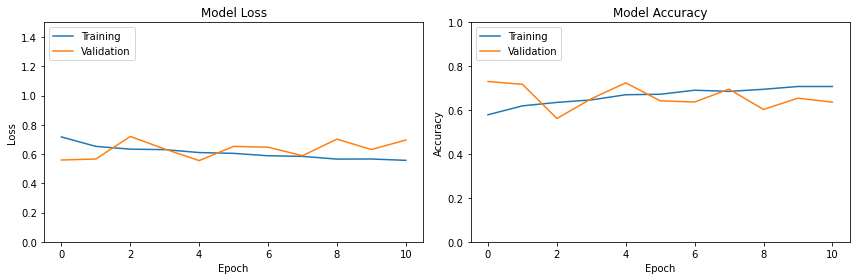

In [23]:
plot_learning_curves(history)

###  1.6 Evaluate model
[Go back to top](#Content:)

In [24]:
def plot_auc(trueY, predY):
    fpr, tpr, _ = skmetrics.roc_curve(trueY, predY)
    roc_auc = skmetrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, 'b', label='AUC=%0.2f'%roc_auc)
    plt.title('AUC', fontsize=14, y=1.03)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return

def plot_pr(precision, recall):
    
    plt.plot(precision, recall, label='%s (AP Score:%0.2f)' % ('Pneumonia', average_precision_score(validY, predY)))
    plt.title('Precision Recall Curve', fontsize=14, y=1.03)
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    return

In [26]:
# model.load_weights(weight_path)
predY = model.predict(validX, batch_size=TRAIN_BATCH_SIZE, verbose=True)

36/36 [==============================] - 8s 211ms/step


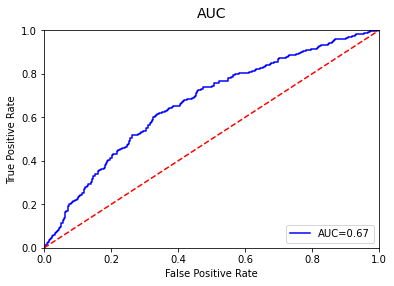

In [27]:
plot_auc(validY, predY)

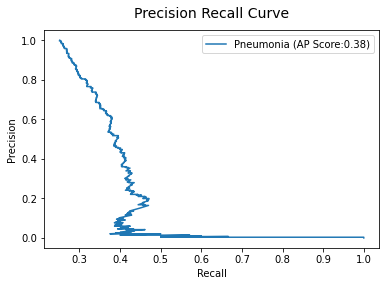

In [28]:
precision, recall, thresholds = precision_recall_curve(validY, predY)
plot_pr(precision, recall)

In [29]:
# A proper classification threshold needs to be determined

def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

def plot_f1_threshold(precision, recall, thresholds):
    f1_scores = []
    
    for i in range(len(thresholds)):
        f1_scores.append(calculate_f1(precision[i], recall[i]))
    
    f1_at_max = max(f1_scores)
    maxIdx = f1_scores.index(f1_at_max)
    threshold_at_max = thresholds[maxIdx]
    precision_at_max = precision[maxIdx]
    recall_at_max = recall[maxIdx]
    
    plt.plot(thresholds, f1_scores)
    plt.title('F1 Score vs Threshold', fontsize=14, y=1.03)
    plt.xlabel('Thresholds')
    plt.ylabel('F1 Score')
    plt.axvline(threshold_at_max, color='darkorange', linestyle='--')
    
    return f1_at_max, precision_at_max, recall_at_max, threshold_at_max

To achieve highest F1 score =  0.46870838881491345
Precision =  0.37849462365591396
Recall =  0.6153846153846154
Threshold =  0.52126944


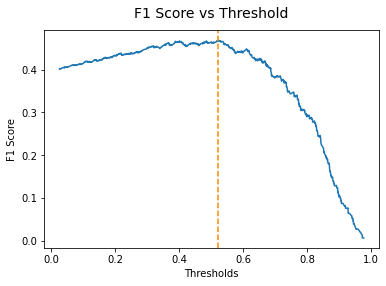

In [30]:
f1, precision, recall, threshold = plot_f1_threshold(precision, recall, thresholds)
print('To achieve highest F1 score = ', f1)
print('Precision = ', precision)
print('Recall = ', recall)
print('Threshold = ', threshold)

In [32]:
probs = predY
predY_binary = (probs > threshold).flatten()
predY_binary = pd.DataFrame(predY_binary)
predY_binary = predY_binary.replace(True, 1).replace(False, 0)

compare = (predY_binary == pd.DataFrame(validY))
compare = compare.replace(True, 1).replace(False, 0)

print('Accuracy at threshold = {:.2f}: {:.2f}%'.format(threshold, sum(compare[0]) / compare.shape[0] * 100))

Accuracy at threshold = 0.52: 65.03%


<Figure size 432x288 with 0 Axes>

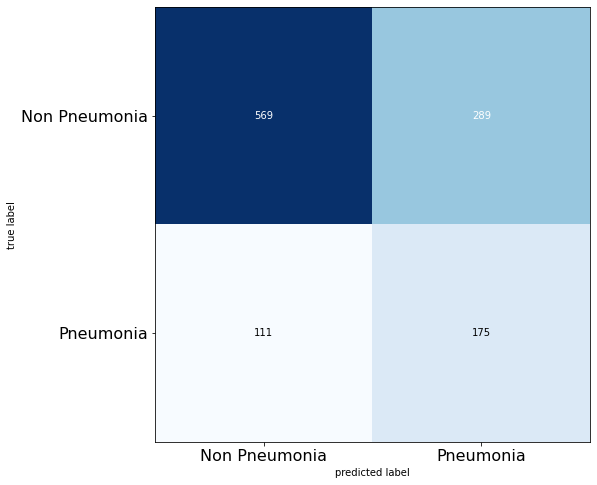

In [35]:
def plot_cm(validY, predY):
    cm = confusion_matrix(validY, predY)
    plt.figure()
    plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Non Pneumonia', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Non Pneumonia', 'Pneumonia'], fontsize=16)

plot_cm(validY, predY_binary)

Accuracy for this sample set = 0.70%


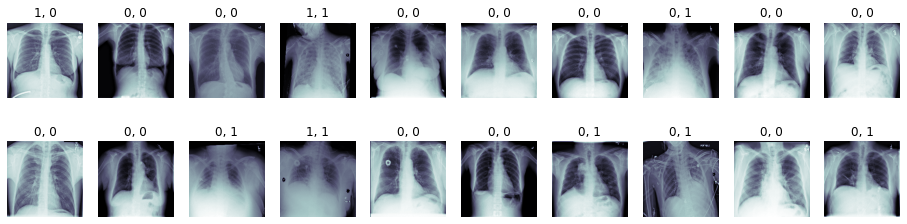

In [36]:
# Let's look at some example of true vs predicted labels with the best model:

fig, ax = plt.subplots(2, 10, figsize=(16, 4))

i = 0
sample_size = 20
correct = 0

for (x, y, ax) in zip(validX[0:sample_size], validY[0:sample_size], ax.flatten()):
    ax.imshow(x[:, :, 0], cmap='bone')
    
    if y == 1:
        if predY[i] > threshold:
            ax.set_title('1, 1')
            correct += 1
        else:
            ax.set_title('1, 0')
    else:
        if predY[i] > threshold:
            ax.set_title('0, 1')
        else:
            ax.set_title('0, 0')
            correct += 1
    ax.axis('off')
    
    i += 1
    
print('Accuracy for this sample set = {:.2f}%'.format(correct/sample_size))

## Part 2. Inference
[Go back to top](#Content:)

In [37]:
import pydicom
from keras.models import model_from_json
from skimage.transform import resize

In [38]:
# This function reads in a single dicom file, checks x-ray postion, examined body part and image type. The return value is a
# numpy array of the image data

def check_dicom(filename):
    print('Loading file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)
    
    if ds.PatientPosition != 'PA' and ds.PatientPosition != 'AP':
        print('The image position is not valid!\n')
        return None
    
    if ds.BodyPartExamined != 'CHEST':
        print('The examined body part is not chest!\n')
        return None
        
    if ds.Modality != 'DX':
        print('The image type is not valid!\n')
        return None
    
    return ds.pixel_array

In [39]:
# This function loads in the trained model/weights and compiles it

def load_model(model_path, weight_path):
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(weight_path)
    return model

In [40]:
# This function takes the numpy array for an image and runs the pre-processing

def preprocess_image(img, img_size):
    
    img = resize(img, (224, 224))
    
    img = img / 255.0
    img_mean = np.mean(img)
    img_std = np.std(img)
    grey_img = (img - img_mean) / img_std
    
    # the model requires size of input to be (1, 224, 224, 3)
    proc_img = np.zeros((224, 224, 3))
    proc_img[:, :, 0] = grey_img
    proc_img[:, :, 1] = grey_img
    proc_img[:, :, 2] = grey_img
    
    proc_img = np.resize(proc_img, img_size)
    
    return proc_img

In [41]:
# This function uses the determined threshold to predict whether or not the image shows the presence of Pneumonia

def predict_image(model, img, threshold):
    result = model.predict(img)
    predict = result[0]
    prediction = 'Negative'
    
    if predict > threshold:
        prediction = 'Positive'
        
    return prediction

In [42]:
dicom_paths = {os.path.basename(x): x for x in glob.glob(os.path.join('../data/test_data', '*.dcm'))}
print(dicom_paths)

{'test1.dcm': '../data/test_data\\test1.dcm', 'test2.dcm': '../data/test_data\\test2.dcm', 'test3.dcm': '../data/test_data\\test3.dcm', 'test4.dcm': '../data/test_data\\test4.dcm', 'test5.dcm': '../data/test_data\\test5.dcm', 'test6.dcm': '../data/test_data\\test6.dcm'}


In [43]:
# For testing purpose: test4 is invalid for wrong examined body part; test5 is invalid for image type; test 6 is invalid for 
# image postion

test_dicoms = ['test1.dcm', 'test2.dcm', 'test3.dcm', 'test4.dcm', 'test5.dcm', 'test6.dcm']

IMG_SIZE = (1, 224, 224, 3)  # required by VGG16

model = load_model(model_path, weight_path)

for dicom in test_dicoms:
    img = np.array([])
    img = check_dicom(dicom_paths.get(dicom))
    
    if img is None:
        continue
    
    img_proc = preprocess_image(img, IMG_SIZE)
    pred = predict_image(model, img_proc, threshold)
    print(pred, '\n')

Loading file ../data/test_data\test1.dcm ...
Negative 

Loading file ../data/test_data\test2.dcm ...
Negative 

Loading file ../data/test_data\test3.dcm ...
Positive 

Loading file ../data/test_data\test4.dcm ...
The examined body part is not chest!

Loading file ../data/test_data\test5.dcm ...
The image type is not valid!

Loading file ../data/test_data\test6.dcm ...
The image position is not valid!

